## Bulk2Space integrates spatial gene expression and histomorphology in pancreatic ductal adenocarcinoma (PDAC)

### Jie Liao<sup>†</sup>,  Jingyang Qian<sup>†</sup>, Yin Fang<sup>†</sup>, Zhuo Chen<sup>†</sup>, Xiang Zhuang<sup>†</sup>, ..., Huajun Chen\*, Xiaohui Fan*

In this tutorial, we will show you an application of Bulk2Space to integrate spatial gene expression and histomorphology in pancreatic ductal adenocarcinoma (PDAC).
The processed [PDAC bulk-seq data (GSE171485)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171485) by Wu et.al., the [PDAC scRNA-seq data and ST data (GSE111672)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE111672) by Moncada et.al. can be downloaded from [here](https://github.com/FowardYang/bulk2space_data).

## Outline
1. [Import modules](#Import-modules)
2. [Parameter definition](#Parameter-definition)
3. [Load data](#Load-data)
4. [Calculate cell type proportions in bulk-seq data](#Celltype-ratio-calculation)
5. [Generate single cell expression from deconvoluted bulk-seq data](#Data-generation)
6. [Evaluation expression correlation of marker genes for cell types between scRNA-seq reference and generated single cells from bulk-seq data](#Data-Evaluation)
7. [Spatial mapping](#Spatial-Mapping)

### 1. <a id="Import-modules">Import modules</a>

In [28]:
from utils.tool import *
from utils.config import cfg, loadArgums
import numpy as np
import pandas as pd
import torch
import scanpy
from scipy.optimize import nnls
from collections import defaultdict
import argparse
import warnings
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')

### 2. <a id="Parameter-definition">Parameter definition</a>

In [ ]:
global args 
args = dict(
    BetaVAE_H=True,
    batch_size=512,
    data_path='pdac_true_bulk',
    dump_path='/home/qjy123/workspace/bulk2space_new/bulk2space/dump',
    epoch_num=3500,
    gpu_id=0,
    early_stop=50,
    hidden_lay=0,
    hidden_size=256,
    input_bulk_path='/home/qjy123/workspace/bulk2space_new/bulk2space/data/pdac_true_bulk/pdac_bulk.csv',
    input_sc_data_path='/home/qjy123/workspace/bulk2space_new/bulk2space/data/pdac_true_bulk/sc_data.csv',
    input_sc_meta_path='/home/qjy123/workspace/bulk2space_new/bulk2space/data/pdac_true_bulk/sc_meta.csv',
    input_st_data_path='/home/qjy123/workspace/bulk2space_new/bulk2space/data/pdac_true_bulk/st_data.csv',
    input_st_meta_path='/home/qjy123/workspace/bulk2space_new/bulk2space/data/pdac_true_bulk/st_meta.csv',
    k=10,
    learning_rate=0.0001,
    marker_used=True,
    model_choice_1='vae', model_choice_2='df',
    load_model_1=False, train_model_2=True,
    not_early_stop=True,
    num_workers=12,
    project_name='pdac_tutorial',
    ratio_num=1,
    spot_data=True,
    top_marker_num=200,
    output_path='/home/qjy123/workspace/bulk2space_new/bulk2space/output_data',
    save='/home/qjy123/workspace/bulk2space_new/bulk2space/save_model',
    random_seed=12345,
    cell_num=10,
    spot_num=500,
    max_cell_in_diff_spot_ratio=None,
    mul_test=5,
    mul_train=1,
    xtest='xtest', xtrain='xtrain', ytest='ytest', ytrain='ytrain'
)
args = argparse.Namespace(**args)

In [3]:
used_device = torch.device(f"cuda:{args.gpu_id}") if args.gpu_id >= 0 and torch.cuda.is_available() else torch.device('cpu')

In [4]:
input_sc_meta_path = args.input_sc_meta_path
input_sc_data_path = args.input_sc_data_path
input_bulk_path = args.input_bulk_path
input_st_meta_path = args.input_st_meta_path
input_st_data_path = args.input_st_data_path

### 3. <a id="Load-data">Load data</a>

In [5]:
print("loading data......")

# load sc_meta.csv file, containing two columns of cell name and cell type
input_sc_meta = pd.read_csv(input_sc_meta_path, index_col=0)
# load sc_data.csv file, containing gene expression of each cell
input_sc_data = pd.read_csv(input_sc_data_path, index_col=0)
sc_gene = input_sc_data._stat_axis.values.tolist()
# load bulk.csv file, containing one column of gene expression in bulk
input_bulk = pd.read_csv(input_bulk_path, index_col=0)
bulk_gene = input_bulk._stat_axis.values.tolist()
# filter overlapping genes.
intersect_gene = list(set(sc_gene).intersection(set(bulk_gene)))
input_sc_data = input_sc_data.loc[intersect_gene]
input_bulk = input_bulk.loc[intersect_gene]
# load st_meta.csv and st_data.csv, containing coordinates and gene expression of each spot respectively.
input_st_meta = pd.read_csv(input_st_meta_path, index_col=0)
input_st_data = pd.read_csv(input_st_data_path, index_col=0)
print("load data ok")

loading data......
load data ok


In [6]:
# Calculate marker genes of each cell type
sc = scanpy.AnnData(input_sc_data.T)
sc.obs = input_sc_meta[['Cell_type']]
scanpy.tl.rank_genes_groups(sc, 'Cell_type', method='wilcoxon')
marker_df = pd.DataFrame(sc.uns['rank_genes_groups']['names']).head(args.top_marker_num)
marker_array = np.array(marker_df)
marker_array = np.ravel(marker_array)
marker_array = np.unique(marker_array)
marker = list(marker_array)
sc_marker = input_sc_data.loc[marker, :]
bulk_marker = input_bulk.loc[marker]

... storing 'Cell_type' as categorical


In [7]:
breed = input_sc_meta['Cell_type']
breed_np = breed.values
breed_set = set(breed_np)
id2label = sorted(list(breed_set))  # List of breed
label2id = {label: idx for idx, label in enumerate(id2label)}  # map breed to breed-id

cell2label = dict()  # map cell-name to breed-id
label2cell = defaultdict(set)  # map breed-id to cell-names
for row in input_sc_meta.itertuples():
    cell_name = getattr(row, 'Cell')
    cell_type = label2id[getattr(row, 'Cell_type')]
    cell2label[cell_name] = cell_type
    label2cell[cell_type].add(cell_name)

label_devide_data = dict()
for label, cells in label2cell.items():
    label_devide_data[label] = sc_marker[list(cells)]

single_cell_splitby_breed_np = {}
for key in label_devide_data.keys():
    single_cell_splitby_breed_np[key] = label_devide_data[key].values  # [gene_num, cell_num]
    single_cell_splitby_breed_np[key] = single_cell_splitby_breed_np[key].mean(axis=1)

max_decade = len(single_cell_splitby_breed_np.keys())
single_cell_matrix = []

for i in range(max_decade):
    single_cell_matrix.append(single_cell_splitby_breed_np[i].tolist())


single_cell_matrix = np.array(single_cell_matrix)
single_cell_matrix = np.transpose(single_cell_matrix)  # (gene_num, label_num)

bulk_marker = bulk_marker.values  # (gene_num, 1)
bulk_rep = bulk_marker.reshape(bulk_marker.shape[0],)

### 4. <a id="Celltype-ratio-calculation">Calculate cell type proportions in bulk-seq data</a>
Bulk2Space firstly calculate the proportion of all cell types in bulk-seq data, which is employed for the subsequent single cells generation.

In [8]:
# calculate cell type proportions in bulk-seq data by NNLS
ratio = nnls(single_cell_matrix, bulk_rep)[0]
ratio = ratio/sum(ratio)
ratio_array = np.round(ratio * input_sc_meta.shape[0] * args.ratio_num)
ratio_list = [r for r in ratio_array]
cell_target_num = dict(zip(id2label, ratio_list))
cell_target_num

{'Acinar cells': 271.0,
 'Cancer clone A': 147.0,
 'Cancer clone B': 253.0,
 'Ductal': 28.0,
 'Endocrine cells': 189.0,
 'Endothelial cells': 191.0,
 'Fibroblasts': 341.0,
 'Macrophages': 9.0,
 'Mast cells': 25.0,
 'Monocytes': 17.0,
 'RBCs': 195.0,
 'T cells   NK cells': 0.0,
 'Tuft cells': 0.0,
 'mDCs': 247.0,
 'pDCs': 13.0}

In [9]:
# *********************************************************************
# input：data， celltype， bulk & output: label, dic, single_cell
single_cell = input_sc_data.values.T  
index_2_gene = (input_sc_data.index).tolist()
breed = input_sc_meta['Cell_type']
breed_np = breed.values
breed_set = set(breed_np)
breed_2_list = list(breed_set)
dic = {}
label = []  # the label of cell (with index correspond)
cfg.nclass = len(breed_set)

cfg.ntrain = single_cell.shape[0]
cfg.FeaSize = single_cell.shape[1]
args.feature_size = single_cell.shape[1]
assert cfg.nclass == len(cell_target_num.keys()), "cell type num no match!!!"

for i in range(len(breed_set)):
    dic[breed_2_list[i]] = i
cell = input_sc_meta["Cell"].values

for i in range(cell.shape[0]):
    label.append(dic[breed_np[i]])

label = np.array(label)

# label index the data size of corresponding target
cell_number_target_num = {}
for k, v in cell_target_num.items():
    cell_number_target_num[dic[k]] = v
# *********************************************************************
# generate data by vae
load_model_1 = args.load_model_1
model_choice_1 = args.model_choice_1

In [10]:
if not load_model_1:  # train
    print("begin vae model training...")
    # ********************* training *********************
    net = train_vae(args, single_cell, cfg, label, used_device)
    # ************** training finished *******************
    print("vae training finished!")
else:  # load model
    print("begin vae model loading...")
    net = load_vae(args, cfg, used_device)
    print("vae load finished!")

begin vae model training...


Train Epoch: 3499: 100%|██████████| 3500/3500 [1:42:22<00:00,  1.76s/it, loss=0.4643, min_loss=0.4610]


min loss = 0.46095629781484604
vae training finished!


### 5. <a id="Data-generation">Generate single cell expression from deconvoluted bulk-seq data</a>

In [11]:
# generate and out put
generate_sc_meta, generate_sc_data = generate_vae(net, args, ratio, single_cell, cfg, label, breed_2_list, index_2_gene, cell_number_target_num, used_device)

Generate Epoch: 68: 100%|██████████| 1926/1926.0 [01:08<00:00, 27.98it/s]

generated done!
begin data to spatial mapping...
Data have been prepared...


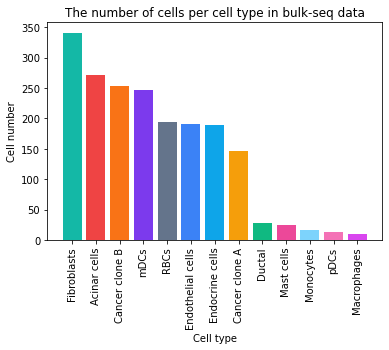

In [21]:
# The number of cells per cell type in deconvoluted bulk-seq data
ct_stat = pd.DataFrame(generate_sc_meta['Cell_type'].value_counts())
ct_name = list(ct_stat.index)
ct_num = list(ct_stat['Cell_type'])
color = ["#14B8A6", "#EF4444", '#F97316', "#7C3AED", '#64748B', '#3B82F6', "#0EA5E9", '#F59E0B', '#10B981', '#EC4899', "#7DD3FC", "#F472B6", "#D946EF"]
plt.bar(ct_name, ct_num, color=color)
plt.xticks(ct_name, ct_name, rotation=90)
plt.title("The number of cells per cell type in bulk-seq data")
plt.xlabel("Cell type")
plt.ylabel("Cell number")
plt.show()

In [22]:
# saving.....
path = osp.join(args.output_path, args.project_name, 'predata')
if not osp.exists(path):
    os.makedirs(path)
name = "vae"
# kl_loss BetaVAE_H
if args.BetaVAE_H:
    name = "BetaVAE"
path_label_generate_csv = os.path.join(path, args.project_name + "_celltype_pred_" + name + "_epoch" + str(args.epoch_num) + '_lr' + str(args.learning_rate) + ".csv")
path_cell_generate_csv = os.path.join(path, args.project_name + "_data_pred_" + name + "_epoch" + str(args.epoch_num) + '_lr' + str(args.learning_rate) + ".csv")

generate_sc_meta.to_csv(path_label_generate_csv)
generate_sc_data.to_csv(path_cell_generate_csv)

print("bulk deconvolution finish!")

print('start to map data to space...')

bulk deconvolution finish!
start to map data to space...


### 6. <a id="Data-Evaluation">Evaluation expression correlation of marker genes for cell types between scRNA-seq reference and generated single cells from bulk-seq data</a>

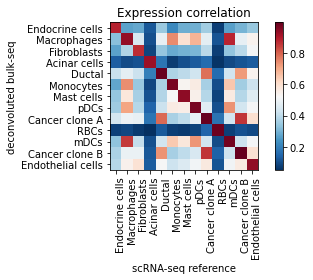

In [29]:
# Expression correlation of marker genes for cell types between scRNA-seq reference and deconvoluted bulk-seq data
# scRNA-seq reference
sc_marker_new = sc_marker.T
sc_marker_new['Cell_type'] = input_sc_meta['Cell_type']
sc_marker_mean = sc_marker_new.groupby('Cell_type')[marker].mean()

# deconvoluted bulk-seq data
generate_sc_meta.index = list(generate_sc_meta['Cell'])
generate_sc_data_new = generate_sc_data.T
generate_sc_data_new['Cell_type'] = generate_sc_meta['Cell_type']
generate_sc_data_mean = generate_sc_data_new.groupby('Cell_type')[marker].mean()

intersect_cell = list(set(sc_marker_mean.index).intersection(set(generate_sc_data_mean.index)))
generate_sc_data_mean= generate_sc_data_mean.loc[intersect_cell]
sc_marker_mean= sc_marker_mean.loc[intersect_cell]

# calculate correlation
sc_marker_mean = sc_marker_mean.T
generate_sc_data_mean = generate_sc_data_mean.T

coeffmat = np.zeros((sc_marker_mean.shape[1], generate_sc_data_mean.shape[1]))
for i in range(sc_marker_mean.shape[1]):    
    for j in range(generate_sc_data_mean.shape[1]):        
        corrtest = pearsonr(sc_marker_mean[sc_marker_mean.columns[i]], generate_sc_data_mean[generate_sc_data_mean.columns[j]])  
        coeffmat[i,j] = corrtest[0]
        
rf_ct = list(sc_marker_mean.columns)
generate_ct = list(generate_sc_data_mean.columns)

# plot
fig, ax = plt.subplots()
im = ax.imshow(coeffmat, cmap='RdBu_r')
ax.set_xticks(np.arange(len(rf_ct)))
ax.set_xticklabels(rf_ct)
ax.set_yticks(np.arange(len(generate_ct)))
ax.set_yticklabels(generate_ct)
plt.xlabel("scRNA-seq reference")
plt.ylabel("deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.colorbar(im)
ax.set_title("Expression correlation")
fig.tight_layout()
plt.show()

### 7. <a id="Spatial-Mapping">Spatial mapping</a>
Here we applied spot-based (Spatial Transcriptomics, ST) spatial transcriptomics data as spatial reference.

In [31]:
# spatial mapping
processer = CreatData(generate_sc_data, generate_sc_meta, input_st_data, args)
processer.cre_data()
runner = Runner(generate_sc_data, generate_sc_meta, input_st_data, input_st_meta, args)
print('start to train the model...')
pred_meta, pred_spot = runner.run()
print("spatial mapping done!")

preparing train data...


... storing 'Cell_type' as categorical


sucessfully create positive data
sucessfully create negative data
save xtrain ok！
save ytrain ok！
train data already prepared.


... storing 'Cell_type' as categorical


load xtrain ok!
load ytrain ok!
select top 200 marker genes of each cell type...
start to train the model...
saving model done!
model trained sucessfully, start saving output ...
Calculating scores...
Calculating scores done.
save csv ok
spatial mapping done!


In [43]:
pred_meta

,Cell,Cell_type,Spot,Spot_xcoord,Spot_ycoord,Cell_xcoord,Cell_ycoord,REG1A,CLDN1,KRT16,MUC5B
C_1,C_1,Endothelial cells,spot_1,10,10,9.68,10.23,0.000000,0.000000,0.000000,0.000000
C_2,C_2,Fibroblasts,spot_1,10,10,9.91,10.05,2.014041,0.000000,0.000000,0.000000
C_3,C_3,Acinar cells,spot_1,10,10,10.04,10.13,7.010150,0.000000,0.000000,0.000000
C_4,C_4,Fibroblasts,spot_1,10,10,9.83,9.81,0.000000,0.000000,0.000000,0.000000
C_5,C_5,Fibroblasts,spot_1,10,10,10.38,10.01,2.084463,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
C_4156,C_4156,Ductal,spot_428,9,33,9.02,32.97,5.416567,0.710963,0.000000,4.512978
C_4157,C_4157,Ductal,spot_428,9,33,8.98,32.55,5.325955,1.205456,0.000000,4.506647
C_4158,C_4158,Cancer clone B,spot_428,9,33,9.30,32.75,0.000000,0.000000,1.235165,0.000000
C_4159,C_4159,Acinar cells,spot_428,9,33,8.64,33.04,6.573702,0.000000,0.000000,0.000000


We firstly investigate the spatial mapping results with single cell resolution, the results showed that the Acinar cells, Cancer cells and Ductal cells have significant spatial distribution patterns, which were consistent with their histomorphology.

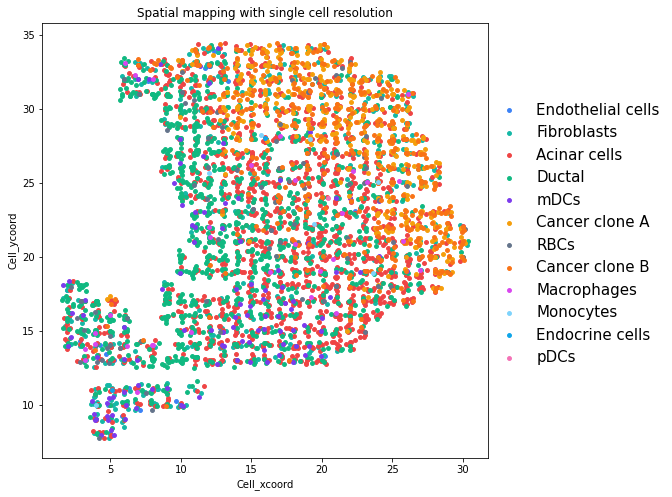

In [46]:
# Spatial mapping with single cell resolution
ct_type = list(pred_meta['Cell_type'].unique())
color = ["#3B82F6", "#14B8A6", '#EF4444', "#10B981", '#7C3AED', '#F59E0B', "#64748B", '#F97316', '#D946EF', '#7DD3FC', "#0EA5E9", "#F472B6"]

fig, ax = plt.subplots(figsize=(8,8))
for i in range(len(ct_type)):
    ax.scatter(pred_meta.loc[pred_meta.Cell_type == ct_type[i], 'Cell_xcoord'],
               pred_meta.loc[pred_meta.Cell_type == ct_type[i], 'Cell_ycoord'],
               color = color[i], label = ct_type[i], s = 15)


plt.title("Spatial mapping with single cell resolution")
plt.xlabel("Cell_xcoord")
plt.ylabel("Cell_ycoord")
plt.legend(bbox_to_anchor=(1, 0.2), loc=3, borderaxespad=0, frameon=False, fontsize=15)
plt.show()    

The spatial expression patterns of marker genes were also consistent with the spatial distribution of cell types.

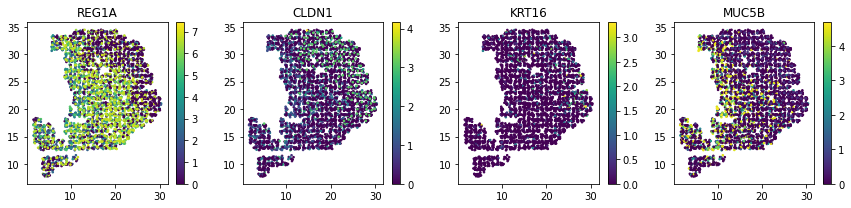

In [47]:
# gene expression
plot = pred_meta
plot.index = list(plot['Cell'])
# 'REG1A': Acinar cells; 'CLDN1': Cancer clone A; 'KRT16': Cancer clone B; 'MUC5B': Ductal
gene = ['REG1A', 'CLDN1', 'KRT16', 'MUC5B']
plot[gene] = pred_spot.T[gene]
xcoord = np.array(plot['Cell_xcoord'])
ycoord = np.array(plot['Cell_ycoord'])
gene1 = np.array(plot['REG1A'])
gene2 = np.array(plot['CLDN1'])
gene3 = np.array(plot['KRT16'])
gene4 = np.array(plot['MUC5B'])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

a = axs[0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene1)
fig.colorbar(a, ax=axs[0])
axs[0].set_title('REG1A')

b = axs[1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene2)
fig.colorbar(b, ax=axs[1])
axs[1].set_title('CLDN1')

c = axs[2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene3)
fig.colorbar(c, ax=axs[2])
axs[2].set_title('KRT16')

d = axs[3].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene4)
fig.colorbar(d, ax=axs[3])
axs[3].set_title('MUC5B')

plt.tight_layout()
plt.show()

We also evaluated the spatial mapping results at spot-level, and as shown in figure, the spatial patterns of different cell types and their marker genes were consistent with their histomorphology.

In [48]:
# spot-level
# calculate cell type proportion per spot
prop = pred_meta[['Cell', 'Cell_type', 'Spot']].pivot_table(index=['Spot'], columns=['Cell_type'], aggfunc='count',values = 'Cell', fill_value=0)
prop = prop.div(prop.sum(axis=1), axis=0)
prop.columns = pd.Index(list(prop.columns))
prop['Spot_xcoord'] = np.array(pred_meta.pivot_table(index=['Spot'])['Spot_xcoord'])
prop['Spot_ycoord'] = np.array(pred_meta.pivot_table(index=['Spot'])['Spot_ycoord'])

# aggregate gene expression per spot
pred_spot_new = pred_spot.T
genes = pred_spot_new.columns
pred_spot_new['Spot'] = pred_meta['Spot']
pred_spot_mean = pred_spot_new.groupby('Spot')[genes].mean()

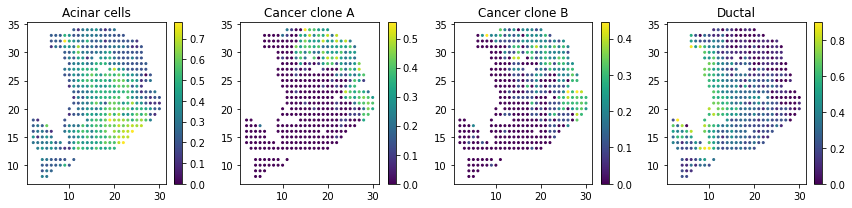

In [49]:
# plot cell type proportion
# Acinar cells; Cancer clone A; Cancer clone B; Ductal
spot_x = np.array(prop['Spot_xcoord'])
spot_y = np.array(prop['Spot_ycoord'])
cell1 = np.array(prop['Acinar cells'])
cell2 = np.array(prop['Cancer clone A'])
cell3 = np.array(prop['Cancer clone B'])
cell4 = np.array(prop['Ductal'])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

a = axs[0].scatter(spot_x, spot_y, s=4, cmap='viridis', c=cell1)
fig.colorbar(a, ax=axs[0])
axs[0].set_title('Acinar cells')

b=axs[1].scatter(spot_x, spot_y, s=4, cmap='viridis', c=cell2)
fig.colorbar(b, ax=axs[1])
axs[1].set_title('Cancer clone A')

c=axs[2].scatter(spot_x, spot_y, s=4, cmap='viridis', c=cell3)
fig.colorbar(c, ax=axs[2])
axs[2].set_title('Cancer clone B')

d=axs[3].scatter(spot_x, spot_y, s=4, cmap='viridis', c=cell4)
fig.colorbar(d, ax=axs[3])
axs[3].set_title('Ductal')

plt.tight_layout()
plt.show()


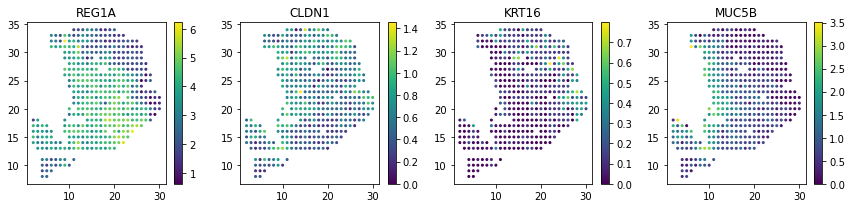

In [50]:
# plot gene expression proportion
# 'REG1A': Acinar cells; 'CLDN1': Cancer clone A; 'KRT16': Cancer clone B; 'MUC5B': Ductal
spot_x = np.array(prop['Spot_xcoord'])
spot_y = np.array(prop['Spot_ycoord'])
g1 = np.array(pred_spot_mean['REG1A'])
g2 = np.array(pred_spot_mean['CLDN1'])
g3 = np.array(pred_spot_mean['KRT16'])
g4 = np.array(pred_spot_mean['MUC5B'])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

a = axs[0].scatter(spot_x, spot_y, s=4, cmap='viridis', c=g1)
fig.colorbar(a, ax=axs[0])
axs[0].set_title('REG1A')

b=axs[1].scatter(spot_x, spot_y, s=4, cmap='viridis', c=g2)
fig.colorbar(b, ax=axs[1])
axs[1].set_title('CLDN1')

c=axs[2].scatter(spot_x, spot_y, s=4, cmap='viridis', c=g3)
fig.colorbar(c, ax=axs[2])
axs[2].set_title('KRT16')

d=axs[3].scatter(spot_x, spot_y, s=4, cmap='viridis', c=g4)
fig.colorbar(d, ax=axs[3])
axs[3].set_title('MUC5B')

plt.tight_layout()
plt.show()